In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
import joblib
import os
import warnings
import gc  # Garbage collector for memory management
from scipy import stats

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Create output directories
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('submission', exist_ok=True)
os.makedirs('advanced_models', exist_ok=True)

In [4]:
# Function to calculate RMSLE (Root Mean Squared Logarithmic Error)
def rmsle(y_true, y_pred):
    """
    Calculate Root Mean Squared Logarithmic Error
    Note: Handles negative predictions by clipping them to a small positive value
    """
    # Ensure predictions are positive (required for log)
    y_pred = np.maximum(y_pred, 1e-5)
    y_true = np.maximum(y_true, 1e-5)
    
    # Calculate RMSLE
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

In [5]:
# Load the data
print("Loading data...")
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Submission shape: {submission.shape}")

Loading data...
Train shape: (750000, 9)
Test shape: (250000, 8)
Submission shape: (250000, 2)


In [6]:
# Display basic information
print("\nTrain data info:")
train.info()


Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [7]:
# Check for missing values
print("\nChecking for missing values:")
print(train.isnull().sum())


Checking for missing values:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


In [8]:
# Basic statistics
print("\nBasic statistics:")
train.describe().T


Basic statistics:


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


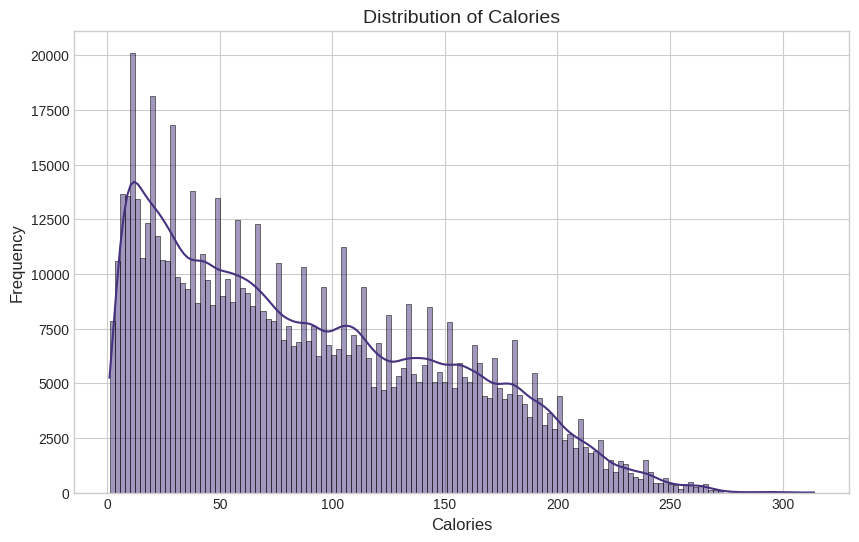

In [9]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['Calories'], kde=True)
plt.title('Distribution of Calories', fontsize=14)
plt.xlabel('Calories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('plots/calories_distribution.png')
plt.show()

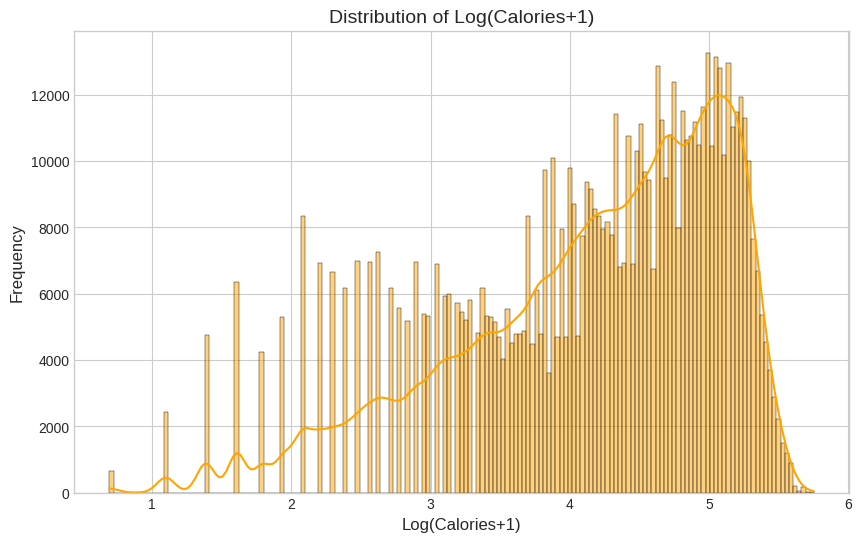

In [10]:
# Log transformation of target variable
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train['Calories']), kde=True, color='orange')
plt.title('Distribution of Log(Calories+1)', fontsize=14)
plt.xlabel('Log(Calories+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('plots/log_calories_distribution.png')
plt.show()


Calculating feature correlations...


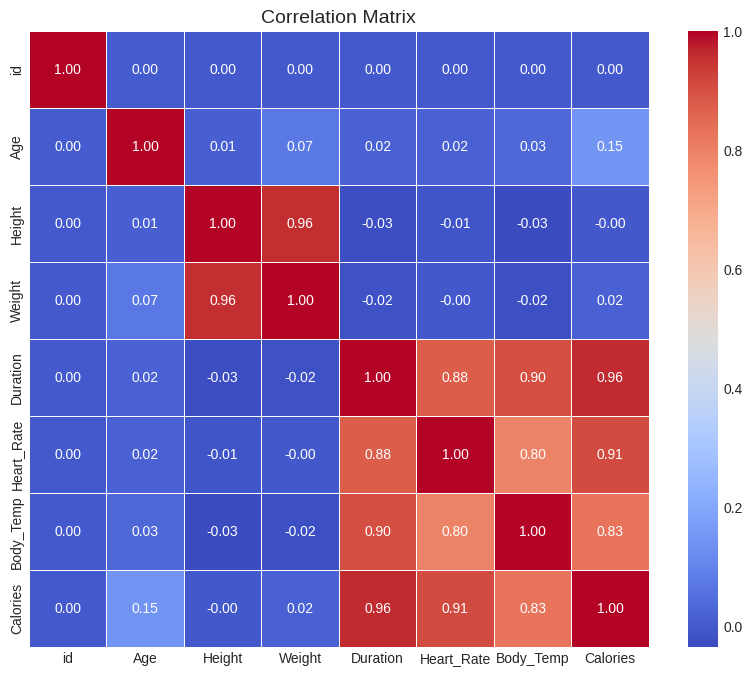

In [11]:
# Correlation analysis
print("\nCalculating feature correlations...")
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
correlation = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14)
plt.savefig('plots/correlation_matrix.png')
plt.show()

In [12]:
# Feature correlation with target
target_corr = correlation['Calories'].sort_values(ascending=False)
print("\nFeature correlation with target (Calories):")
print(target_corr)


Feature correlation with target (Calories):
Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
id            0.001148
Height       -0.004026
Name: Calories, dtype: float64


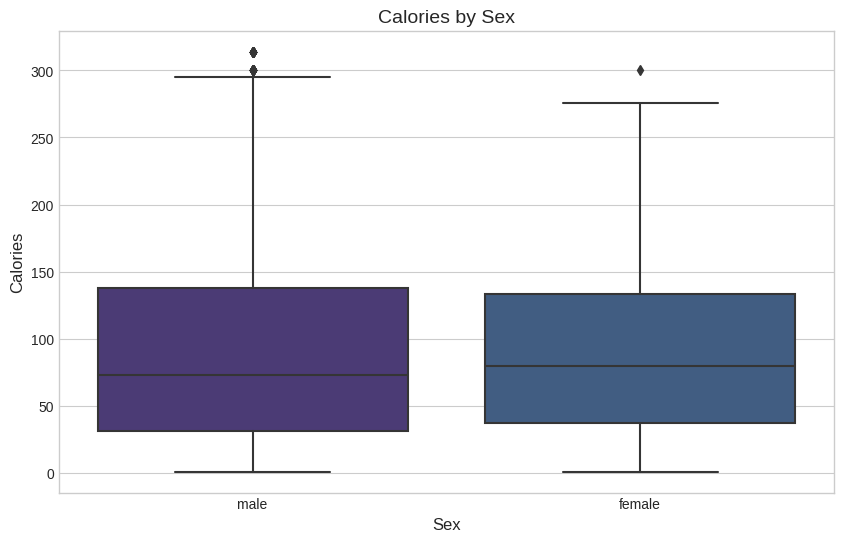

In [13]:
# Calories by Sex
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Calories', data=train)
plt.title('Calories by Sex', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Calories', fontsize=12)
plt.savefig('plots/calories_by_sex.png')
plt.show()

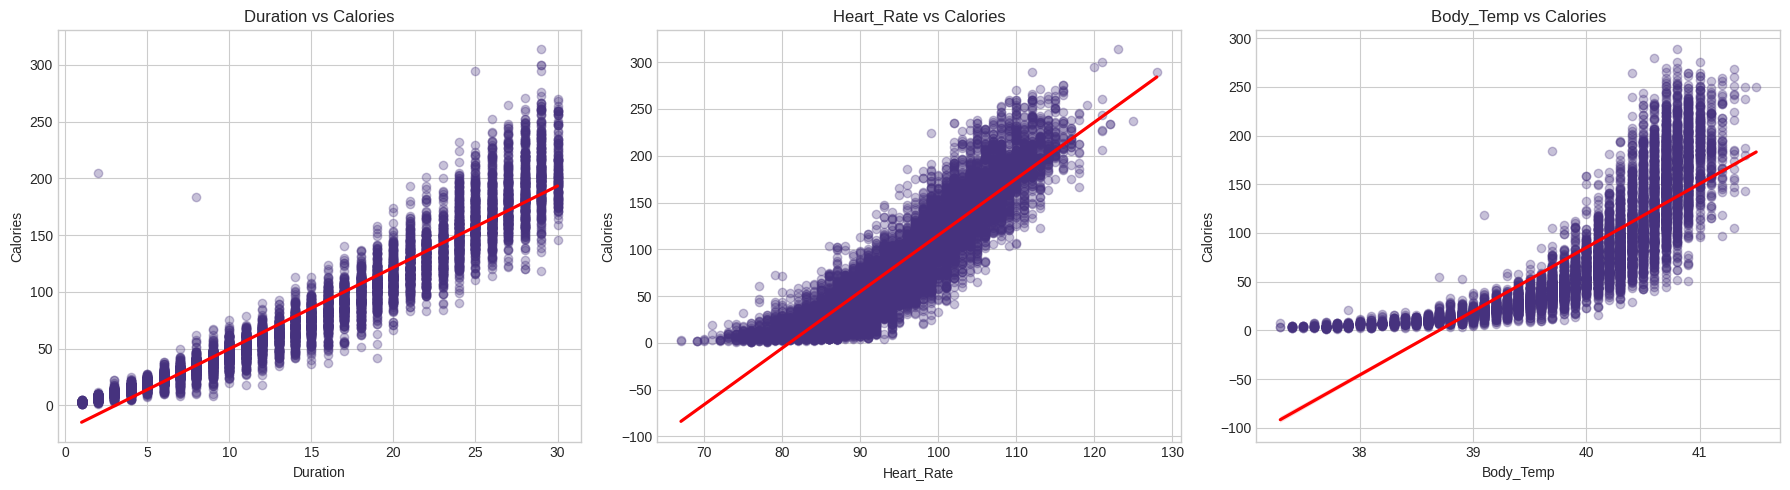

In [14]:
# Key feature relationships with target
key_features = ['Duration', 'Heart_Rate', 'Body_Temp']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(key_features):
    sns.regplot(x=feature, y='Calories', data=train.sample(10000), ax=axes[i], 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[i].set_title(f'{feature} vs Calories', fontsize=12)
    
plt.tight_layout()
plt.savefig('plots/key_features_vs_calories.png')
plt.show()

In [15]:
# Create a function for advanced feature engineering to apply to both train and test
def advanced_feature_engineering(df):
    """
    Apply advanced feature engineering to the dataset
    """
    # Create a copy to avoid modifying the original
    df_new = df.copy()
    
    # Basic features from original engineering
    df_new['BMI'] = df_new['Weight'] / ((df_new['Height']/100) ** 2)
    df_new['Sex_male'] = (df_new['Sex'] == 'male').astype(int)
    
    # Age groups with more granularity
    df_new['Age_Group'] = pd.cut(df_new['Age'], 
                              bins=[19, 25, 30, 35, 40, 45, 50, 55, 60, 80], 
                              labels=list(range(9)))
    df_new['Age_Group'] = df_new['Age_Group'].astype(int)
    
    # BMI categories (underweight, normal, overweight, obese)
    df_new['BMI_Category'] = pd.cut(df_new['BMI'], 
                                 bins=[0, 18.5, 25, 30, 100], 
                                 labels=[0, 1, 2, 3])
    df_new['BMI_Category'] = df_new['BMI_Category'].astype(int)
    
    # Advanced interaction features
    df_new['Duration_Heart'] = df_new['Duration'] * df_new['Heart_Rate']
    df_new['Weight_Heart'] = df_new['Weight'] * df_new['Heart_Rate']
    df_new['BMI_Duration'] = df_new['BMI'] * df_new['Duration']
    df_new['Heart_Temp'] = df_new['Heart_Rate'] * df_new['Body_Temp']
    df_new['Duration_Temp'] = df_new['Duration'] * df_new['Body_Temp']
    df_new['Age_Heart'] = df_new['Age'] * df_new['Heart_Rate']
    df_new['Weight_Duration'] = df_new['Weight'] * df_new['Duration']
    
    # Polynomial features for key variables
    df_new['Duration_Squared'] = df_new['Duration'] ** 2
    df_new['Heart_Rate_Squared'] = df_new['Heart_Rate'] ** 2
    df_new['Body_Temp_Squared'] = df_new['Body_Temp'] ** 2
    
    # Ratios and normalized features
    df_new['Heart_Rate_by_Age'] = df_new['Heart_Rate'] / df_new['Age']
    df_new['Duration_by_Weight'] = df_new['Duration'] / df_new['Weight']
    df_new['Heart_Rate_by_Weight'] = df_new['Heart_Rate'] / df_new['Weight']
    
    # Logarithmic transformations for skewed features
    df_new['Log_Duration'] = np.log1p(df_new['Duration'])
    df_new['Log_Heart_Rate'] = np.log1p(df_new['Heart_Rate'])
    df_new['Log_Weight'] = np.log1p(df_new['Weight'])
    
    # Trigonometric transformations to capture cyclical patterns
    df_new['Sin_Heart_Rate'] = np.sin(df_new['Heart_Rate'] / 200 * np.pi)
    df_new['Cos_Heart_Rate'] = np.cos(df_new['Heart_Rate'] / 200 * np.pi)
    
    # Interaction between categorical and continuous features
    df_new['Sex_Duration'] = df_new['Sex_male'] * df_new['Duration']
    df_new['Sex_Heart'] = df_new['Sex_male'] * df_new['Heart_Rate']
    df_new['Sex_BMI'] = df_new['Sex_male'] * df_new['BMI']
    df_new['Age_Group_Heart'] = df_new['Age_Group'] * df_new['Heart_Rate']
    
    # Statistical aggregations
    df_new['Feature_Sum'] = df_new['Duration'] + df_new['Heart_Rate'] + df_new['Body_Temp']
    df_new['Feature_Mean'] = (df_new['Duration'] + df_new['Heart_Rate'] + df_new['Body_Temp']) / 3
    
    # Drop original Sex column as we've encoded it
    df_new.drop('Sex', axis=1, inplace=True)
    
    return df_new

# Apply advanced feature engineering
print("Applying advanced feature engineering...")
train_fe = advanced_feature_engineering(train)
test_fe = advanced_feature_engineering(test)

print("\nEngineered train data shape:", train_fe.shape)
print("Engineered test data shape:", test_fe.shape)

print("\nNew features added:")
new_features = set(train_fe.columns) - set(train.columns) | {'Sex_male'}
print(len(new_features), "new features")
print(new_features)

Applying advanced feature engineering...

Engineered train data shape: (750000, 36)
Engineered test data shape: (250000, 35)

New features added:
28 new features
{'Sex_BMI', 'Log_Duration', 'BMI_Category', 'BMI', 'Age_Group_Heart', 'Age_Heart', 'Duration_Heart', 'Sex_Heart', 'Sin_Heart_Rate', 'Duration_Temp', 'Heart_Rate_by_Weight', 'Feature_Sum', 'Log_Heart_Rate', 'Age_Group', 'Weight_Heart', 'Heart_Temp', 'Sex_male', 'Log_Weight', 'Body_Temp_Squared', 'Heart_Rate_by_Age', 'Cos_Heart_Rate', 'Sex_Duration', 'Feature_Mean', 'Duration_by_Weight', 'Heart_Rate_Squared', 'Weight_Duration', 'Duration_Squared', 'BMI_Duration'}


In [16]:
# Split features and target
X = train_fe.drop(['Calories', 'id'], axis=1)
y = train_fe['Calories']
X_test = test_fe.drop(['id'], axis=1)

# Log transform the target (since RMSLE is the evaluation metric)
y_log = np.log1p(y)


Checking for outliers in target variable...
Number of outliers detected: 312


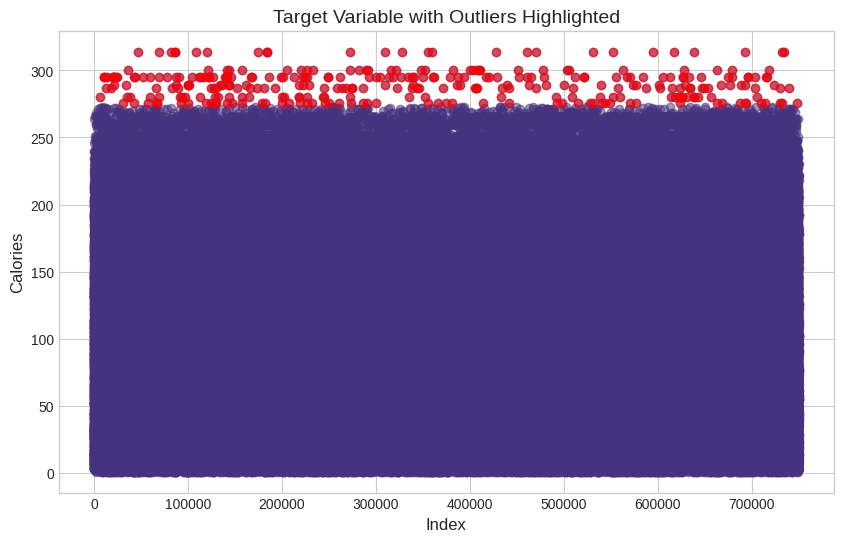

In [17]:
# Check for outliers in the target variable
print("\nChecking for outliers in target variable...")
z_scores = stats.zscore(y)
outliers = (abs(z_scores) > 3)
print(f"Number of outliers detected: {np.sum(outliers)}")

# Plot outliers
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y)), y, alpha=0.5)
plt.scatter(np.where(outliers)[0], y[outliers], color='red', alpha=0.5)
plt.title('Target Variable with Outliers Highlighted', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Calories', fontsize=12)
plt.savefig('advanced_models/outliers.png')
plt.show()

In [18]:
# Create a version of the dataset with outliers removed for comparison
X_no_outliers = X[~outliers]
y_no_outliers = y[~outliers]
y_log_no_outliers = y_log[~outliers]

print(f"Dataset shape after outlier removal: {X_no_outliers.shape}")

Dataset shape after outlier removal: (749688, 34)


In [19]:
# Train-validation split with stratification on binned target
y_bins = pd.qcut(y, q=10, labels=False)
X_train, X_val, y_train, y_val, y_log_train, y_log_val, y_bins_train, y_bins_val = train_test_split(
    X, y, y_log, y_bins, test_size=0.2, random_state=42, stratify=y_bins)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (600000, 34)
Validation set: (150000, 34)


In [20]:
# Standardize features
print("Standardizing features...")
preprocessor = StandardScaler()

# Fit preprocessor on training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

Standardizing features...


In [21]:
# Best CatBoost parameters from optimization
best_catboost_params = {
    'iterations': 2998,
    'learning_rate': 0.016933195141294204,
    'depth': 10,
    'l2_leaf_reg': 1.02482828209293e-08,
    'border_count': 255,
    'bagging_temperature': 4.773325130759612,
    'random_strength': 0.1321531285154764,
    'verbose': False,
    'random_seed': 42
}

print("Training optimized CatBoost model...")
cb_model = cb.CatBoostRegressor(**best_catboost_params)
cb_model.fit(X_train_scaled, y_log_train, eval_set=(X_val_scaled, y_log_val), early_stopping_rounds=100, verbose=False)

Training optimized CatBoost model...


In [22]:
# Evaluate CatBoost model
y_pred_cb_log = cb_model.predict(X_val_scaled)
y_pred_cb = np.expm1(y_pred_cb_log)
rmsle_cb = rmsle(y_val, y_pred_cb)
r2_cb = r2_score(y_val, y_pred_cb)

print(f"CatBoost - RMSLE: {rmsle_cb:.6f}, R²: {r2_cb:.6f}")

CatBoost - RMSLE: 0.059552, R²: 0.996786


In [23]:
# Perform cross-validation on the optimized model
print("\nPerforming cross-validation on optimized CatBoost model...")

# Function for cross-validation with RMSLE
def rmsle_cv_score(model, X, y_log, cv=5):
    """Calculate cross-validation RMSLE score"""
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        # Use .iloc for positional indexing with pandas Series
        y_log_train_cv, y_val_cv = y_log.iloc[train_idx], np.expm1(y_log.iloc[val_idx])
        
        # Train model
        model.fit(X_train_cv, y_log_train_cv, verbose=False)
        
        # Predict and calculate RMSLE
        y_pred_log = model.predict(X_val_cv)
        y_pred = np.expm1(y_pred_log)
        score = rmsle(y_val_cv, y_pred)
        rmsle_scores.append(score)
    
    return rmsle_scores

# Sample size for cross-validation (to manage memory constraints)
SAMPLE_SIZE = 200000
np.random.seed(42)
idx = np.random.choice(len(X_train_scaled), SAMPLE_SIZE, replace=False)
X_train_sample = X_train_scaled[idx]
y_log_train_sample = y_log_train.iloc[idx]

print(f"Running 5-fold cross-validation on CatBoost with {SAMPLE_SIZE} samples...")
cv_scores = rmsle_cv_score(cb_model, X_train_sample, y_log_train_sample, cv=5)

print(f"Cross-validation RMSLE scores: {cv_scores}")
print(f"Mean CV RMSLE: {np.mean(cv_scores):.6f}")
print(f"Standard deviation: {np.std(cv_scores):.6f}")


Performing cross-validation on optimized CatBoost model...
Running 5-fold cross-validation on CatBoost with 200000 samples...
Cross-validation RMSLE scores: [0.06102195928008416, 0.0603193529054909, 0.06149293979627794, 0.06072238266897548, 0.05746198674652303]
Mean CV RMSLE: 0.060204
Standard deviation: 0.001423


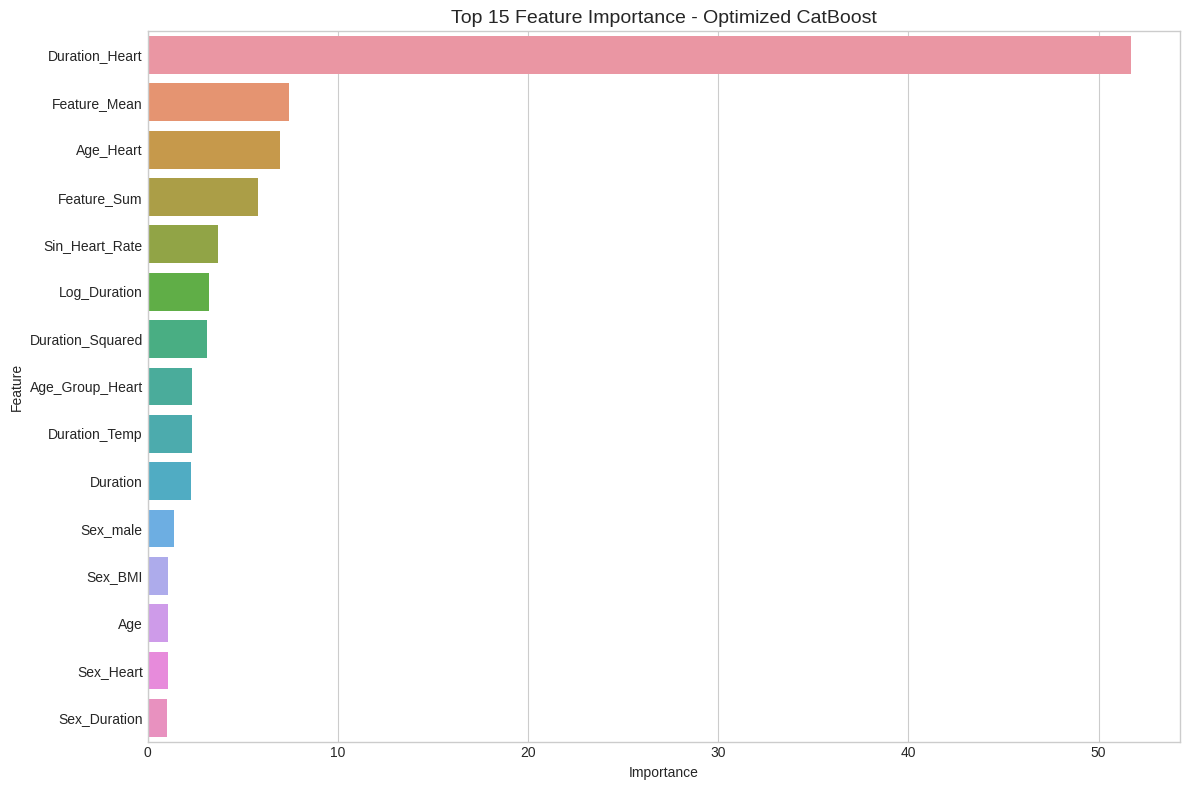

In [24]:
# Feature importance for CatBoost model
feature_importance = cb_model.get_feature_importance()

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title(f'Top 15 Feature Importance - Optimized CatBoost', fontsize=14)
plt.tight_layout()
plt.savefig('advanced_models/catboost_feature_importance.png')
plt.show()

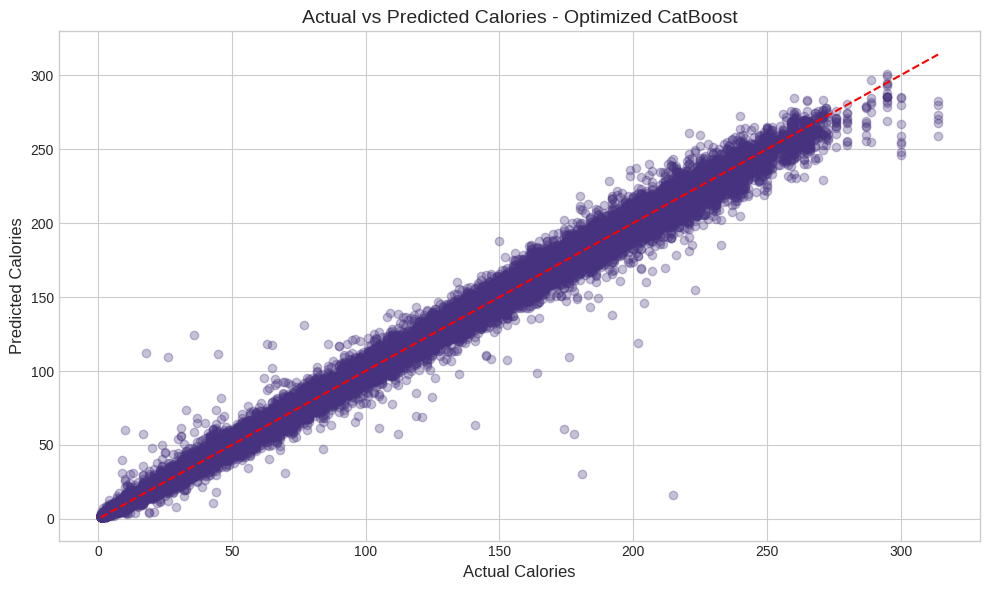

In [25]:
# Plot actual vs predicted values for CatBoost model
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_cb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Calories', fontsize=12)
plt.ylabel('Predicted Calories', fontsize=12)
plt.title(f'Actual vs Predicted Calories - Optimized CatBoost', fontsize=14)
plt.tight_layout()
plt.savefig('advanced_models/catboost_actual_vs_predicted.png')
plt.show()

In [26]:
# Generate predictions for test set
print("Generating predictions for test set...")
test_pred_cb_log = cb_model.predict(X_test_scaled)
test_pred_cb = np.expm1(test_pred_cb_log)

# Create submission dataframe
submission_final = pd.DataFrame({
    'id': test['id'],
    'Calories': test_pred_cb
})

# Verify submission format
print("\nSubmission format verification:")
print(f"Shape: {submission_final.shape}")
print("First 5 rows:")
print(submission_final.head())

Generating predictions for test set...

Submission format verification:
Shape: (250000, 2)
First 5 rows:
       id    Calories
0  750000   27.125749
1  750001  107.821724
2  750002   86.618798
3  750003  125.747474
4  750004   76.176950


In [27]:
# Check for invalid values (negative or NaN)
invalid_count = np.sum(np.isnan(test_pred_cb) | (test_pred_cb < 0))
if invalid_count > 0:
    print(f"WARNING: Found {invalid_count} invalid predictions (NaN or negative).")
    # Replace invalid values with minimum valid value (1.0)
    submission_final['Calories'] = np.maximum(submission_final['Calories'].fillna(1.0), 1.0)
    print("Invalid values have been replaced with 1.0")
else:
    print("All predictions are valid (no NaN or negative values).")

All predictions are valid (no NaN or negative values).


In [28]:
# Check prediction distribution
print("\nPrediction statistics:")
print(submission_final['Calories'].describe())


Prediction statistics:
count    250000.000000
mean         88.179729
std          62.276266
min           0.966624
25%          34.015856
50%          76.424425
75%         135.296377
max         300.090637
Name: Calories, dtype: float64


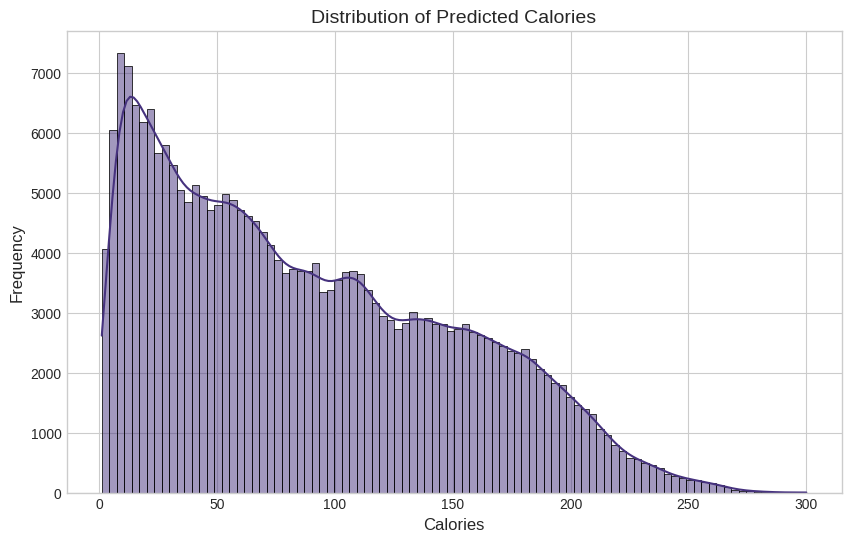

In [29]:
# Plot prediction distribution
plt.figure(figsize=(10, 6))
sns.histplot(submission_final['Calories'], kde=True)
plt.title('Distribution of Predicted Calories', fontsize=14)
plt.xlabel('Calories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('advanced_models/prediction_distribution.png')
plt.show()

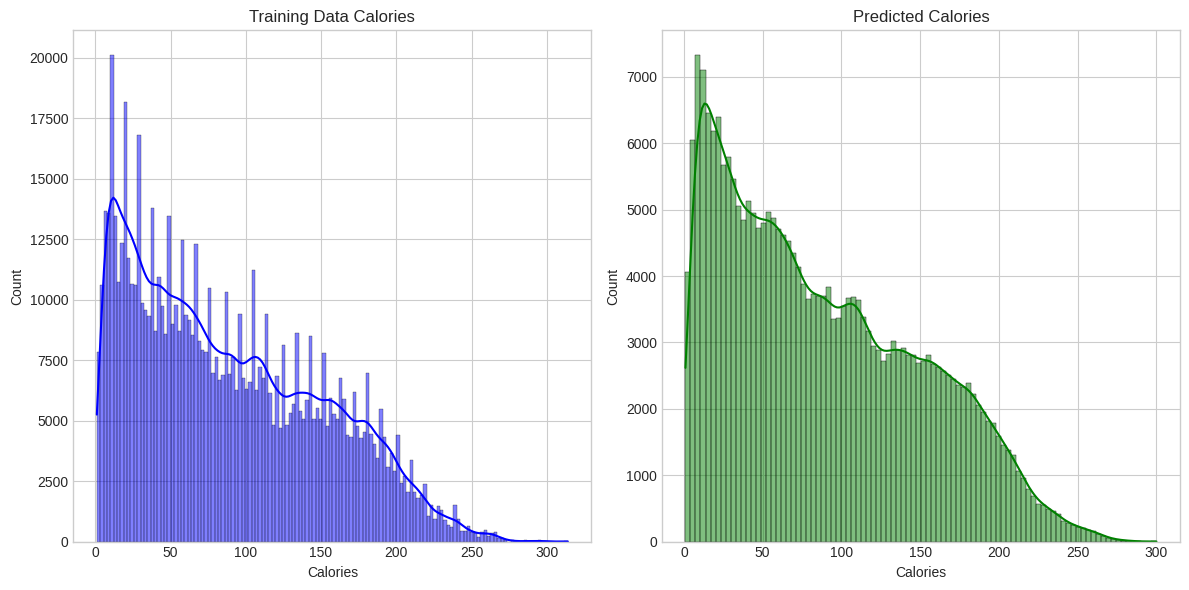

In [30]:
# Compare with training data distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['Calories'], kde=True, color='blue')
plt.title('Training Data Calories', fontsize=12)
plt.xlabel('Calories', fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(submission_final['Calories'], kde=True, color='green')
plt.title('Predicted Calories', fontsize=12)
plt.xlabel('Calories', fontsize=10)

plt.tight_layout()
plt.savefig('advanced_models/train_vs_prediction_distribution.png')
plt.show()

In [43]:
# Save submission file
submission_path = 'advanced_models/advanced_submission.csv'
submission_final.to_csv(submission_path, index=False)
print(f"\nFinal submission file saved to {submission_path}")


Final submission file saved to advanced_models/advanced_submission.csv


In [44]:
# Compare with sample submission format
if submission_final.shape == submission.shape and all(submission_final.columns == submission.columns):
    print("Submission format matches the sample submission format.")
else:
    print("WARNING: Submission format doesn't match the sample submission format!")
    print(f"Sample shape: {submission.shape}, Our shape: {submission_final.shape}")
    print(f"Sample columns: {submission.columns}, Our columns: {submission_final.columns}")

Submission format matches the sample submission format.


In [45]:

print(os.listdir('/kaggle/working/advanced_models'))


['train_vs_prediction_distribution.png', 'catboost_actual_vs_predicted.png', 'outliers.png', 'prediction_distribution.png', 'catboost_feature_importance.png', 'advanced_submission.csv']


In [47]:
from IPython.display import FileLink

# Create a download link
FileLink('/kaggle/working/advanced_models/submission.csv')


/kaggle/working/advanced_models/submission.csv